# MAHTS stats

## Background


## Description



## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [2]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import deacoastlines_statistics as dcl_stats

import os
import sys
import geopandas as gpd
from shapely.geometry import box
from rasterio.transform import array_bounds
import pandas as pd
import shutil

sys.path.append('../Scripts')
from dea_spatialtools import subpixel_contours

## Load in data

In [106]:
# Read in contours
study_area = 2523
output_name = 'refactor'
water_index = 'mndwi'
index_threshold = 0.00
baseline_year = '2018'

# Create output vector folder
output_dir = f'output_data/{study_area}_{output_name}/vectors'
os.makedirs(f'{output_dir}/shapefiles', exist_ok=True)

## Load DEA CoastLines rasters

In [107]:
yearly_ds = dcl_stats.load_rasters(output_name, study_area, water_index)
yearly_ds

<xarray.Dataset>
Dimensions:         (x: 1747, y: 1062, year: 31)
Coordinates:
  * x               (x) float64 4.256e+05 4.256e+05 ... 4.779e+05 4.78e+05
  * y               (y) float64 -3.739e+06 -3.739e+06 ... -3.771e+06 -3.771e+06
  * year            (year) int64 1988 1989 1990 1991 ... 2015 2016 2017 2018
Data variables:
    mndwi           (year, y, x) float32 -0.539932 -0.539876 ... 0.34285712
    gapfill_index   (year, y, x) float32 -0.4966795 -0.49705443 ... 0.29446223
    gapfill_tide_m  (year, y, x) float32 -0.04995364 -0.049943924 ... 0.01801306
    gapfill_count   (year, y, x) int16 19 19 20 19 19 19 ... 72 72 72 74 74 74
    stdev           (year, y, x) float32 0.10323176 0.10781701 ... 0.40579978
    tide_m          (year, y, x) float32 0.026019773 0.026007598 ... 0.016973095
    count           (year, y, x) int16 7 7 7 7 7 7 7 7 ... 24 25 25 25 26 25 25
Attributes:
    crs:        +init=epsg:32651
    transform:  | 30.00, 0.00, 425565.00|\n| 0.00,-30.00,-3738735.00|\n| 0.00...

## Load external data

In [478]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(box(*array_bounds(height=yearly_ds.sizes['y'], 
                                       width=yearly_ds.sizes['x'], 
                                       transform=yearly_ds.transform)), 
                     crs=yearly_ds.crs)

# Estaury mask
estuary_gdf = (gpd.read_file('input_data/estuary_mask.shp', bbox=bbox)
               .to_crs(yearly_ds.crs))

# Rocky shore mask
smartline_gdf = (gpd.read_file('input_data/Smartline.gdb', bbox=bbox)
                 .to_crs(yearly_ds.crs))

# Tide points
points_gdf = (gpd.read_file('input_data/tide_points_coastal.geojson', bbox=bbox)
          .to_crs(yearly_ds.crs))

# Study area polygon
comp_gdf = (gpd.read_file('input_data/50km_albers_grid.shp', bbox=bbox)
            .set_index('id')
            .to_crs(str(yearly_ds.crs)))

# Mask to study area
study_area_poly = comp_gdf.loc[study_area]

# Load climate indices
climate_df = pd.read_csv('input_data/climate_indices.csv', index_col='year')


## Extract shoreline contours

### Extract ocean-masked contours

In [116]:
# Mask dataset to focus on coastal zone only
masked_ds = dcl_stats.contours_preprocess(yearly_ds, 
                                          water_index, 
                                          index_threshold, 
                                          estuary_gdf, 
                                          points_gdf)

# Extract contours
contours_gdf = subpixel_contours(da=masked_ds,
                                 z_values=index_threshold,
                                 min_vertices=5,
                                 dim='year',
                                 output_path='test3.geojson').set_index('year')

Operating in single z-value, multiple arrays mode
Writing contours to test3.geojson


## Compute statistics
### Measure distances from baseline

In [465]:
# Extract statistics modelling points along baseline contour
points_gdf = dcl_stats.stats_points(contours_gdf, baseline_year, distance=30)

# Clip to remove rocky shoreline points
points_gdf = dcl_stats.rocky_shores_clip(points_gdf, smartline_gdf, buffer=50)


### Compute annual coastline movements

In [466]:
if points_gdf is not None:
    
    # Make a copy of the points GeoDataFrame to hold tidal data
    tide_points_gdf = points_gdf.copy()

    # Calculate annual movements and residual tide heights for every contour
    # compared to the baseline year
    points_gdf, tide_points_gdf = dcl_stats.annual_movements(yearly_ds, 
                                                             points_gdf, 
                                                             tide_points_gdf, 
                                                             contours_gdf, 
                                                             baseline_year,
                                                             water_index)

In [467]:
# Restrict climate and points data to years in datasets
x_years = yearly_ds.year.values
points_subset = points_gdf[x_years.astype(str)]
tide_subset = tide_points_gdf[x_years.astype(str)]
climate_subset = climate_df.loc[x_years, :]

In [259]:
import pandas as pd
num_pd = pd.Series([3, 5, 8, 4, 400, 6, 7, 2, 1, -1, -3, 0, -101, -5, -1])
large_change = num_pd.diff().abs() > 100
offbyone = num_pd.shift(periods=1)
large_change_off_by_one = offbyone.diff().abs() > 100
num_pd.where(~(large_change & ~large_change_off_by_one))

0     3.0
1     5.0
2     8.0
3     4.0
4     NaN
5     6.0
6     7.0
7     2.0
8     1.0
9    -1.0
10   -3.0
11    0.0
12    NaN
13   -5.0
14   -1.0
dtype: float64

In [289]:
num_pd = pd.Series([3,2,4,3,-100,0,101,2,3,4,2,34])
large_change = num_pd.diff().abs() > 100
offbyone = num_pd.shift(periods=1)
large_change_off_by_one = offbyone.diff().abs() > 100
num_pd.where(~(large_change & ~large_change_off_by_one))

0      3.0
1      2.0
2      4.0
3      3.0
4      NaN
5      0.0
6      NaN
7      2.0
8      3.0
9      4.0
10     2.0
11    34.0
dtype: float64

In [297]:
import pandas
# x = pandas.Series([0, 1, 2, 3, -100, 0, 1, 2, 3, 150, 0, 0, 101, 0, 5])


x = points_subset2

outlier = (x.diff(axis=1).abs() > 100).astype(int).diff(axis=1) > 0




x.where(~outlier).head()

,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0.0,1.66,-1.05,1.11,-4.23,-8.14,-7.30,-8.66,-7.77,-13.85,...,-8.93,-10.38,NaN,-147.78,-126.86,NaN,-78.99,-8.00,NaN,-26.11
1,0.0,3.47,3.11,2.80,-8.75,-12.41,-8.50,-14.35,-14.00,-22.73,...,-28.55,-28.78,NaN,-147.97,-127.49,-44.72,-82.56,-32.49,NaN,-46.75
2,0.0,2.69,-3.79,6.75,2.65,-0.19,1.98,-4.11,-5.42,-10.39,...,-7.36,-7.66,NaN,-124.79,-104.89,-38.06,-67.97,-35.15,NaN,-51.84
3,0.0,1.91,-0.62,13.44,9.77,8.31,3.78,1.14,2.73,-5.56,...,1.70,-4.59,NaN,-100.46,-85.59,-25.71,-58.05,-19.30,-93.17,-35.34
4,0.0,1.20,10.02,11.69,12.10,13.92,8.08,11.13,8.45,-4.84,...,4.04,-3.45,-93.47,-83.51,-78.48,-17.61,-65.14,-20.58,-57.50,-23.03


In [298]:
x.head()

,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0.0,1.66,-1.05,1.11,-4.23,-8.14,-7.30,-8.66,-7.77,-13.85,...,-8.93,-10.38,-154.22,-147.78,-126.86,-13.40,-78.99,-8.00,-159.22,-26.11
1,0.0,3.47,3.11,2.80,-8.75,-12.41,-8.50,-14.35,-14.00,-22.73,...,-28.55,-28.78,-154.31,-147.97,-127.49,-44.72,-82.56,-32.49,-158.08,-46.75
2,0.0,2.69,-3.79,6.75,2.65,-0.19,1.98,-4.11,-5.42,-10.39,...,-7.36,-7.66,-131.03,-124.79,-104.89,-38.06,-67.97,-35.15,-136.52,-51.84
3,0.0,1.91,-0.62,13.44,9.77,8.31,3.78,1.14,2.73,-5.56,...,1.70,-4.59,-105.64,-100.46,-85.59,-25.71,-58.05,-19.30,-93.17,-35.34
4,0.0,1.20,10.02,11.69,12.10,13.92,8.08,11.13,8.45,-4.84,...,4.04,-3.45,-93.47,-83.51,-78.48,-17.61,-65.14,-20.58,-57.50,-23.03


In [304]:
import numpy as np, pandas
x = pandas.Series([0, -0.26, 0.04, -5.1, -6.35, -6.55, -0.22, -1.07, -1.25, -27.87, 1.8, 4.55, 4.95, -66.71, -56.66, -1.62, -1.55,43.6,1008,-1.53,0.21,4.37,-64.9,-285.44,-394.91,-422.77,-431.98,-50.13,-57.24,-27,-29.25])
threshold = 20
filtered = x.rolling(5, center=True).median()
outliers = (x - filtered).abs() > threshold
x.where(~outliers)

0       0.00
1      -0.26
2       0.04
3      -5.10
4      -6.35
5      -6.55
6      -0.22
7      -1.07
8      -1.25
9        NaN
10      1.80
11      4.55
12      4.95
13       NaN
14       NaN
15     -1.62
16     -1.55
17       NaN
18       NaN
19     -1.53
20      0.21
21      4.37
22    -64.90
23   -285.44
24   -394.91
25       NaN
26       NaN
27    -50.13
28    -57.24
29    -27.00
30    -29.25
dtype: float64

In [307]:
X.shape

(1000, 1)

In [309]:
y.shape

(1000,)

Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [-5.55197984] [0.19162488]


/g/data/v10/public/modules/dea-env/20200313/lib/python3.6/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


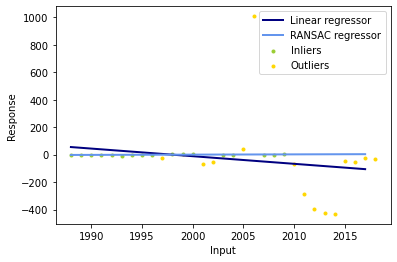

In [326]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


# X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
#                                       n_informative=1, noise=10,
#                                       coef=True, random_state=0)

# # Add outlier data
# np.random.seed(0)
# X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
# y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)



X = x_years.reshape((31, 1))
y = pandas.Series([0, -0.26, 0.04, -5.1, -6.35, -6.55, -0.22, -1.07, -1.25, -27.87, 1.8,
                   4.55, 4.95, -66.71, -56.66, -1.62, -1.55,43.6,1008,-1.53,0.21,4.37,-64.9,
                   -285.44,-394.91,-422.77,-431.98,-50.13,-57.24,-27,-29.25])


# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='top right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

In [323]:
ransac.score(X=X, y=y)

-0.017984038064079666


m=0.078, c=-158.311
R^2: 0.043, RMSE: 2.388


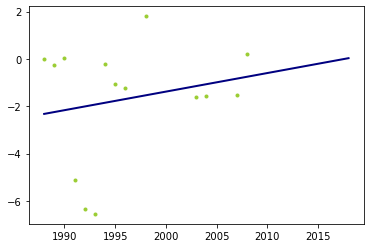

In [387]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

# Data
x = x_years
y = pandas.Series([0, -0.26, 0.04, -5.1, -6.35, -6.55, -0.22, -1.07, -1.25, 
                   -27.87, 1.8, 4.55, 4.95, -66.71, -56.66, -1.62, -1.55,43.6,
                   1008,-1.53,0.21,4.37,-64.9,-285.44,-394.91,-422.77,-431.98,
                   -50.13,-57.24,-27,-29.25])



# Proper shape
x, y = np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1)

# Fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor(stop_n_inliers=15)

# Run regression 10 times with the same raw data
# for _ in range(10):
ransac.fit(x, y)

# Estimated coefficients
m, c = float(ransac.estimator_.coef_), float(ransac.estimator_.intercept_)
print("\nm={:.3f}, c={:.3f}".format(m, c))

# R^2 & RMSE statistics
inlier_mask = ransac.inlier_mask_
x_accpt, y_accpt = x[inlier_mask], y[inlier_mask]
y_predict = m * x_accpt + c
R2 = r2_score(y_accpt, y_predict)
RMSE = np.sqrt(mean_squared_error(y_accpt, y_predict))
print("R^2: {:.3f}, RMSE: {:.3f}".format(R2, RMSE))

# line_y = lr.predict(x)
line_y_ransac = ransac.predict(x)

plt.scatter(x[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')

# plt.scatter(x[~inlier_mask], y[~inlier_mask], color='red', marker='.',
#             label='Outliers')


plt.plot(x, line_y_ransac, color='navy', linewidth=lw, label='Linear regressor')

In [ ]:
print(boston_df_o1 < (Q1 - 1.5 * IQR)) |(boston_df_o1 > (Q3 + 1.5 * IQR
                                                         
                                                         Q1 = boston_df_o1.quantile(0.25)
Q3 = boston_df_o1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [422]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


is_outlier(y, thresh=7)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False, False, False,  True,  True,  True,  True,
       False, False, False, False])

In [427]:
is_outlier(y, thresh=7), y[:,0])

ValueError: either both or neither of x and y should be given

In [432]:
y = pandas.Series([0, -0.26, 0.04, -5.1, -6.35, -6.55, -0.22, -1.07, -1.25, 
                   -27.87, 1.8, 4.55, 4.95, -66.71, -56.66, -1.62, -1.55,43.6,
                   1008,-1.53,0.21,4.37,-64.9,-285.44,-394.91,-422.77,-431.98,
                   -50.13,-57.24,-27,-29.25])

y[is_outlier(y, thresh=3.5)] = np.nan
y

0      0.00
1     -0.26
2      0.04
3     -5.10
4     -6.35
5     -6.55
6     -0.22
7     -1.07
8     -1.25
9    -27.87
10     1.80
11     4.55
12     4.95
13      NaN
14      NaN
15    -1.62
16    -1.55
17      NaN
18      NaN
19    -1.53
20     0.21
21     4.37
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29   -27.00
30   -29.25
dtype: float64

In [453]:
from scipy import stats

row = pandas.Series([0, -0.26, 0.04, -5.1, -6.35, -6.55, -0.22, -1.07, -1.25, 
                   -27.87, 1.8, 4.55, 4.95, -66.71, -56.66, -1.62, -1.55,43.6,
                   1008,-1.53,0.21,4.37,-64.9,-285.44,-394.91,-422.77,-431.98,
                   -50.13,-57.24,-27,-29.25])
x_vals = x_years
x_labels = x_years
std_dev = 2


# Extract x (time) and y (distance) values
x = x_vals
y = row.values.astype(np.float)

# Drop NAN rows
xy_df = np.vstack([x, y]).T
is_valid = ~np.isnan(xy_df).any(axis=1)
xy_df = xy_df[is_valid]
valid_labels = x_labels[is_valid]   

# Remove outliers
# outlier_bool = (np.abs(stats.zscore(xy_df)) < float(std_dev)).all(axis=1)
outlier_bool = ~is_outlier(y, thresh=3.5)
xy_df = xy_df[outlier_bool]

In [455]:
stats.zscore(xy_df)

array([[-1.32755733,  0.45619704],
       [-1.21110493,  0.43087981],
       [-1.09465253,  0.460092  ],
       [-0.97820014, -0.0404102 ],
       [-0.86174774, -0.16212766],
       [-0.74529534, -0.18160245],
       [-0.62884295,  0.43477477],
       [-0.51239055,  0.35200689],
       [-0.39593815,  0.33447958],
       [-0.27948575, -2.25761544],
       [-0.16303336,  0.63147018],
       [-0.04658096,  0.89924859],
       [ 0.06987144,  0.93819818],
       [ 0.41922863,  0.29845121],
       [ 0.53568103,  0.30526739],
       [ 0.88503822,  0.30721487],
       [ 1.00149062,  0.47664557],
       [ 1.11794301,  0.88172128],
       [ 2.04956219, -2.17290009],
       [ 2.16601459, -2.39199152]])

In [155]:
points_subset.loc[:,year_on_year.index[year_on_year]]

,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,1.66,-1.05,1.11,-4.23,-8.14,-7.30,-8.66,-7.77,-13.85,-7.62,...,-8.93,-10.38,-154.22,-147.78,-126.86,-13.40,-78.99,-8.00,-159.22,-26.11
1,3.47,3.11,2.80,-8.75,-12.41,-8.50,-14.35,-14.00,-22.73,-14.60,...,-28.55,-28.78,-154.31,-147.97,-127.49,-44.72,-82.56,-32.49,-158.08,-46.75
2,2.69,-3.79,6.75,2.65,-0.19,1.98,-4.11,-5.42,-10.39,-7.64,...,-7.36,-7.66,-131.03,-124.79,-104.89,-38.06,-67.97,-35.15,-136.52,-51.84
3,1.91,-0.62,13.44,9.77,8.31,3.78,1.14,2.73,-5.56,-5.94,...,1.70,-4.59,-105.64,-100.46,-85.59,-25.71,-58.05,-19.30,-93.17,-35.34
4,1.20,10.02,11.69,12.10,13.92,8.08,11.13,8.45,-4.84,-5.56,...,4.04,-3.45,-93.47,-83.51,-78.48,-17.61,-65.14,-20.58,-57.50,-23.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4497,-7.22,-5.46,-1.32,-1.51,-1.22,-0.46,1.33,0.16,-10.38,-9.58,...,-2.36,-4.81,-7.11,-7.71,-4.26,-8.19,-10.25,-9.15,-8.70,-6.72
4498,-8.39,-5.41,0.59,-2.45,-2.60,0.89,2.40,1.02,-13.31,-11.92,...,-0.76,-7.52,-12.84,-7.08,-5.93,-6.73,-11.28,-9.97,-12.43,-9.81
4499,-3.87,-4.37,-2.08,-1.45,-1.37,-0.09,0.69,-0.36,-5.47,-4.64,...,0.51,-4.29,-6.54,-7.49,-1.87,-3.67,-5.00,-5.47,-4.45,-3.49
4500,-3.03,-3.58,-1.15,0.16,1.03,1.31,3.07,1.18,-1.96,-0.67,...,0.80,-2.66,-4.95,-7.83,-1.59,-2.30,-1.85,-3.17,-3.71,-3.08


### Calculate regressions

In [479]:
if points_gdf is not None:

    points_gdf = dcl_stats.calculate_regressions(yearly_ds, 
                                                 points_gdf, 
                                                 tide_points_gdf, 
                                                 climate_df)

KeyError: "None of [Index(['1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',\n       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',\n       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',\n       '2015', '2016', '2017', '2018'],\n      dtype='object')] are in the [columns]"

In [477]:
climate_subset

,SOI,IOD,SAM,IPO,PDO
year,,,,,
1988,0.736667,0.052417,-0.321500,-0.592417,-0.077500
1989,0.616667,-0.112833,0.640000,-0.665583,-0.551667
1990,-0.325833,-0.009167,-0.181250,-0.043083,-0.856667
1991,-1.013333,0.354500,-0.582083,0.407917,-0.933333
1992,-1.227500,-0.315250,-0.638500,0.823750,0.699167
1993,-1.106667,0.084833,0.567000,0.788750,0.973333
1994,-1.353333,0.620167,0.059917,0.485500,-0.534167
1995,-0.335833,0.135500,0.174500,0.152583,0.320000
1996,0.562500,-0.207250,-0.193583,-0.180333,0.610000


In [473]:
points_subset.shape

(4379, 31)

In [474]:
(tide_subset.apply(lambda x: dcl_stats.change_regress(row=points_subset.iloc[x.name],
                                                x_vals=x, 
                                                x_labels=x_years,
                                                std_dev=2), axis=1))

,slope,intercept,pvalue,outliers
0,-160.333,-8.734,0.130,2001 2002 2011 2012 2013 2015 2017
1,-300.617,-24.513,0.325,2002 2011 2012 2013 2017
2,-370.218,-10.178,0.042,2001 2002 2003 2011 2012 2013 2015 2017
3,-336.076,-5.350,0.015,2002 2011 2012 2013 2015 2017
4,-540.264,-7.482,0.018,2002 2011 2012 2013
...,...,...,...,...
4374,35.768,-5.948,0.332,
4375,31.220,-5.809,0.439,
4376,0.544,-2.774,0.979,
4377,-7.946,-1.381,0.731,


In [464]:
(points_gdf
                .apply(lambda x: points_subset.iloc[x.name]))

TypeError: Cannot index by location index with a non-integer key

## Export files

### Export stats files

In [120]:
if points_gdf is not None:

    # Clip stats to study area extent, remove rocky shores
    stats_path = f'{output_dir}/stats_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
    points_gdf = points_gdf[points_gdf.intersects(study_area_poly['geometry'])]

    # Export to GeoJSON
    points_gdf.to_file(f'{stats_path}.geojson', driver='GeoJSON')

    # Export as ESRI shapefiles
    stats_path = stats_path.replace('vectors', 'vectors/shapefiles')
    points_gdf.to_file(f'{stats_path}.shp')

### Export contours

In [121]:
# Clip annual shoreline contours to study area extent
contour_path = f'{output_dir}/contours_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
contours_gdf['geometry'] = contours_gdf.intersection(study_area_poly['geometry'])
contours_gdf.reset_index().to_file(f'{contour_path}.geojson', driver='GeoJSON')

# Export stats and contours as ESRI shapefiles
contour_path = contour_path.replace('vectors', 'vectors/shapefiles')
contours_gdf.to_file(f'{contour_path}.shp')

### Create zip file

In [115]:
# Create a zip file containing all vector files
shutil.make_archive(base_name=f'output_data/outputs_{study_area}_{output_name}', 
                    format='zip', 
                    root_dir=output_dir)

'/g/data1a/r78/rt1527/dea-notebooks/MAHTS/output_data/outputs_2523_refactor.zip'

### Copy all GeoJSON to folder

In [6]:
!find /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/ -type f -path '*_refactor/vectors/*geojson' -exec cp -u '{}' /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/geojson/ ';'

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2020